**Our main goal:** To train a binary segmentation model that separates blood vessels from other parts of inner eye in a retinal image.

**Our main tasks here are:**
1. Generate train/val datasets based on `tf.data` api
2. Make a model for image segmentation based on [U-NET architecture](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)
3. Train the model
4. Analyze the results using test dataset

In [1]:
# Installing additional packages
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 4.3 MB/s 


In [2]:
# Only if opened in a Colab notebook. Else -> just import the packages from the current working dir
# Download model package
!wget https://raw.githubusercontent.com/pavelg0t/studies/main/Computer_vision_in_medicine_2021_fall/HW_1/model/U_net_model.py
# Download Dataset package
!wget https://raw.githubusercontent.com/pavelg0t/studies/main/Computer_vision_in_medicine_2021_fall/HW_1/datasets/Dataset.py
# Download Metrics package
!wget https://raw.githubusercontent.com/pavelg0t/studies/main/Computer_vision_in_medicine_2021_fall/HW_1/metrics/Metrics.py

--2021-10-25 13:55:06--  https://raw.githubusercontent.com/pavelg0t/studies/main/Computer_vision_in_medicine_2021_fall/HW_1/model/U_net_model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8107 (7.9K) [text/plain]
Saving to: ‘U_net_model.py’

U_net_model.py      100%[===================>]   7.92K  --.-KB/s    in 0s      

2021-10-25 13:55:06 (93.0 MB/s) - ‘U_net_model.py’ saved [8107/8107]

--2021-10-25 13:55:06--  https://raw.githubusercontent.com/pavelg0t/studies/main/Computer_vision_in_medicine_2021_fall/HW_1/datasets/Dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
H

In [3]:
# Importing our own classes
# -> If 'U_net_model' and 'Dataset' should be in the same folder
import U_net_model 
import Dataset 
import Metrics

# Importing libraries
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, LearningRateScheduler
import keras.backend as K
import numpy as np
from PIL import Image
import random
import math
from sklearn.metrics import roc_curve, auc
from datetime import date
from google.colab import drive
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
import pandas as pd

%load_ext tensorboard
%matplotlib inline

In [4]:
#Mounting Google Drive
drive.mount('/content/gdrive')
os.chdir('gdrive/MyDrive/VGTU/Kompiuterine_rega_medicinoje/ND_nr_1')

Mounted at /content/gdrive


**1. Generating train/val datasets using `tf.data` API.**

Defining a list of paths pointing to images. Every element of a lis is a tuple: first item -> is a path to a RGB image, second -> path to segmentation mask. 

In [5]:
img_path = 'unified_data/train/images_128px'
mask_path = 'unified_data/train/vessels_masks_128px'

im_pairs = [ (os.path.join(img_path,file),os.path.join(mask_path,file)) for file in os.listdir(img_path)]
random.shuffle(im_pairs)
print(len(im_pairs))

2180


In [6]:
BATCH_SIZE = 16
split_ration = 0.975

ds_train_128, ds_val_128 = Dataset.generate_dataset(im_pairs,BATCH_SIZE,split_ration)

Check the returned batches

In [ ]:
for batch in ds_train_128.take(1):
  print([elem.numpy().shape for elem in batch])

[(16, 128, 128, 3), (16, 128, 128, 1), (16, 128, 128, 1)]


In [ ]:
def visualize_batch_items(batch,elem_ids,col_names,img_size=5):
  ncol = len(batch)
  nrow = len(elem_ids)
  fig , ax = plt.subplots(nrow, ncol, figsize=(ncol*img_size,img_size*nrow))

  for i in range(nrow):
    for j in range(ncol):

      im = np.array(batch[j][elem_ids[i]])
      if im.shape[-1] ==1:
        im = np.squeeze(im)

      im0 = ax[i][j].imshow( im )
      divider = make_axes_locatable(ax[i][j])
      cax = divider.append_axes('right', size='5%', pad=0.05)
      fig.colorbar(im0, cax=cax, orientation='vertical')
      ax[i][j].title.set_text(col_names[j])

Lets visualize few elements in the returned batch of images

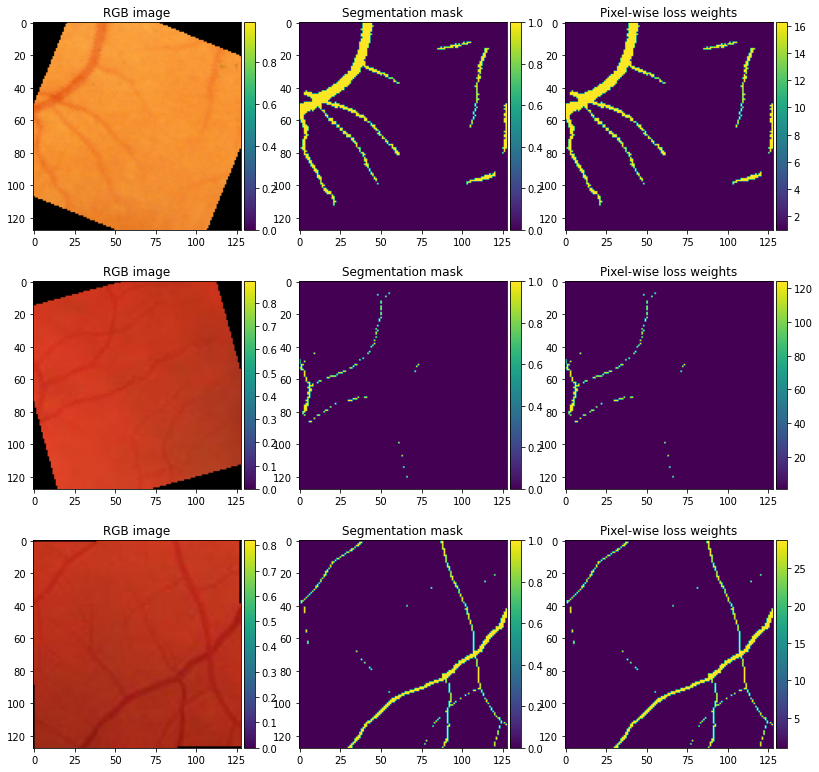

In [ ]:
batch = next(iter(ds_train_128.take(1)))

elem_ids=[1,2,3]
col_names = ["RGB image", "Segmentation mask", "Pixel-wise loss weights"]
visualize_batch_items(batch,elem_ids,col_names,img_size=4.5)

**2. Compiling our custome model (based on [U-NET architecture](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/))**

In [7]:
model_128 = U_net_model.get_model(WIDTH=128,HEIGHT=128,INPT_CHANNELS=3,N_ch=16)

In [8]:
metrics = [tf.keras.metrics.AUC()]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # default lr 

# Compiling out models
model_128.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)

Manage model saving and other logs

In [9]:
# Creating folder for model/logs saving
if not os.path.exists('models_128'):
  os.mkdir('models_128')
if not os.path.exists('logs_128'):
  os.mkdir('logs_128')

save_folder_128 = os.path.join('models_128',str(date.today()))
logs_folder_128 = os.path.join('logs_128',str(date.today()))

if not os.path.exists(save_folder_128):
  os.mkdir(save_folder_128)
if not os.path.exists(logs_folder_128):
  os.mkdir(logs_folder_128)

checkpoint_path_128 = os.path.join(save_folder_128,'model.h5')

In [10]:
# Defining usefull callbacks
def step_decay(epoch, lr):
  lr_0 = 0.001
  drop = 0.5
  epochs_drop = 15.0
  lrate = lr_0 * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return lrate

callbacks_128 = [
  ModelCheckpoint(filepath=checkpoint_path_128, monitor="val_loss", verbose=1, save_best_only=True),
  EarlyStopping( monitor="val_loss", patience=15, verbose=1),
  TensorBoard(log_dir=logs_folder_128),
  LearningRateScheduler(step_decay)
]

**3.  Training the model (using 128x128px patches)**


In [ ]:
history = model_128.fit(x=ds_train_128, validation_data=ds_val_128, epochs=65, verbose=1, callbacks=callbacks_128)

Epoch 1/65
133/133 [==============================] - 1392s 10s/step - loss: 0.7523 - auc: 0.8855 - val_loss: 2.0391 - val_auc: 0.5475

Epoch 00001: val_loss improved from inf to 2.03912, saving model to models_128/2021-10-25/model.h5
Epoch 2/65
133/133 [==============================] - 15s 110ms/step - loss: 0.4454 - auc: 0.9606 - val_loss: 1.0663 - val_auc: 0.8943

Epoch 00002: val_loss improved from 2.03912 to 1.06629, saving model to models_128/2021-10-25/model.h5
Epoch 3/65
133/133 [==============================] - 15s 112ms/step - loss: 0.4006 - auc: 0.9672 - val_loss: 0.5327 - val_auc: 0.9598

Epoch 00003: val_loss improved from 1.06629 to 0.53265, saving model to models_128/2021-10-25/model.h5
Epoch 4/65
133/133 [==============================] - 15s 111ms/step - loss: 0.3605 - auc: 0.9721 - val_loss: 0.4139 - val_auc: 0.9713

Epoch 00004: val_loss improved from 0.53265 to 0.41392, saving model to models_128/2021-10-25/model.h5
Epoch 5/65
133/133 [============================

Visualing training stats

In [ ]:
print(history.params)
print(history.history.keys())

{'verbose': 1, 'epochs': 65, 'steps': 133}
dict_keys(['loss', 'auc', 'val_loss', 'val_auc', 'lr'])


In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_auc = history.history['auc']
val_auc = history.history['val_auc']
epochs = range(1,len(train_loss)+1)

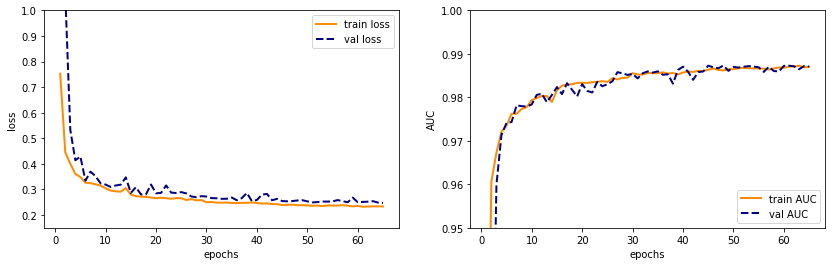

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(14,4))

ax[0].plot(epochs, train_loss, color='darkorange', lw=2, label='train loss')
ax[0].plot(epochs, val_loss, color='navy', lw=2, linestyle='--', label='val loss')
ax[0].set_ylim([0.15, 1.0])
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[0].legend(loc="upper right")

ax[1].plot(epochs, train_auc, color='darkorange', lw=2, label='train AUC')
ax[1].plot(epochs, val_auc, color='navy', lw=2, linestyle='--', label='val AUC')
ax[1].set_ylim([0.95, 1.0])
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('AUC')
ax[1].legend(loc="lower right")

**4. Testing the model**

Creating test data set

In [20]:
test_rgb = 'unified_data/test/images'
test_mask = 'unified_data/test/vessels_masks'

test_im_paths = [ (os.path.join(test_rgb,file),os.path.join(test_mask,file)) for file in os.listdir(test_rgb)]
print(len(test_im_paths))

20


Defining few functions

In [21]:
def plot_pred_results(imgs,titles,pic_size=3):

  ncol = len(imgs[0])
  nrow = len(imgs)
  fig , ax = plt.subplots(nrow, ncol, figsize=(pic_size*ncol,pic_size*nrow))

  for i in range(ncol*nrow):
    if len(imgs[i//ncol][i%ncol].shape)==3:
      im0 = ax[i//ncol][i%ncol].imshow( imgs[i//ncol][i%ncol] )
    else:
      divider = make_axes_locatable(ax[i//ncol][i%ncol])
      cax = divider.append_axes('right', size='5%', pad=0.05)
      im0 = ax[i//ncol][i%ncol].imshow( imgs[i//ncol][i%ncol], cmap='gray' )
      fig.colorbar(im0, cax=cax, orientation='vertical')

    ax[i//ncol][i%ncol].title.set_text( titles[i%ncol] )
    ax[i//ncol][i%ncol].set_axis_off()

In [22]:
def infere_imgs(test_im_paths, thresh = 0.9):
  imgs = []
  # Loading few images
  for im_pair in tqdm(test_im_paths):
    with Image.open(im_pair[0]) as im_RGB:
      im = tf.convert_to_tensor(np.array(im_RGB))
      pred = U_net_model.predict(model_128, im, patch_size=128)
      pred = np.squeeze(np.array(pred))
      pred_thr = pred > thresh
      pred_thr = pred_thr.astype(int)
    with Image.open(im_pair[1]) as im_mask:
      truth = np.array(im_mask)/255
      truth = truth.astype(int)
    imgs.append([pred, pred_thr, truth, np.array(im_RGB)])

  return imgs

Loading the model one want to test

In [23]:
# Load the best model
model_128 = tf.keras.models.load_model(os.path.join(save_folder_128,'model.h5'))

Infere few examples from the test data set

In [24]:
N=3 #Number of samples to visualize
threshold = 0.8 # classification threshold
results = infere_imgs(test_im_paths[:N],thresh = threshold)

100%|██████████| 3/3 [00:36<00:00, 12.21s/it]


**4.1 Visualize prediction examples**

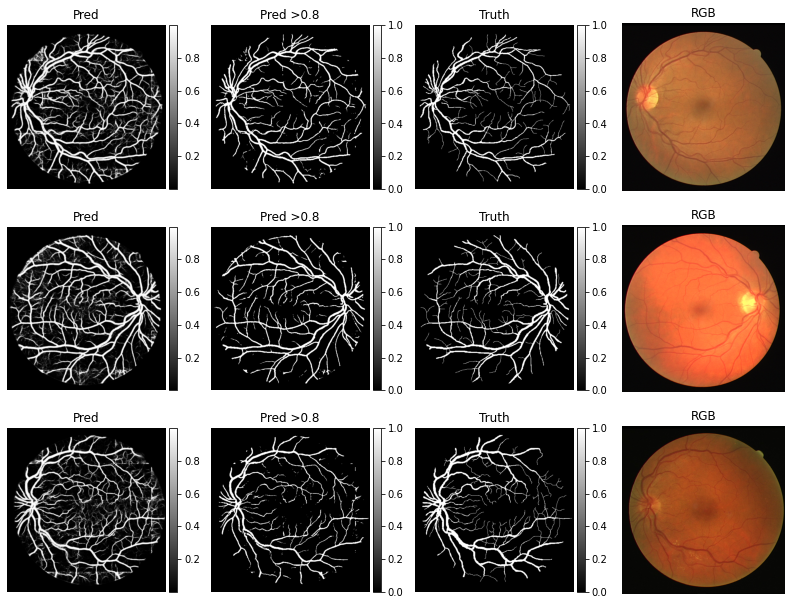

In [25]:
titles = ['Pred', 'Pred >'+str(threshold),'Truth','RGB']
plot_pred_results(results, titles,pic_size=3.5)

**4.2 Model evaluation**

Inference on the whole test data

In [26]:
results = infere_imgs(test_im_paths)
preds = [res[0] for res in results]
truth = [res[2] for res in results]

100%|██████████| 20/20 [00:30<00:00,  1.53s/it]


Flattening infered images for metric calculation

In [27]:
preds_1D = np.empty(0)
truth_1D = np.empty(0)

for i in range(len(preds)):
  preds_1D = np.concatenate((preds_1D, preds[i].flatten() ))
  truth_1D = np.concatenate((truth_1D, truth[i].flatten() ))

**4.2.1 Calculating main metrics (by default `threshold = 0.5`)**

In [28]:
metrics = {"Recall": Metrics.get_Recall,
           "Precision": Metrics.get_Precision,
           "F1": Metrics.get_F1}

cols = ['metric','class 0','class 1','mean','weighted']
df_1 = pd.DataFrame(columns=cols)

# Calculating the main metrics
for i, m_name in tqdm(enumerate(metrics.keys())):
  res = metrics[m_name](truth_1D,preds_1D)
  df_1 = df_1.append(pd.DataFrame(res,index=[i]))

df_1.set_index('metric',inplace=True)
df_1

3it [00:19,  6.43s/it]


,class 0,class 1,mean,weighted
metric,,,,
Recall,0.931,0.925,0.928,0.931
Precision,0.992,0.564,0.778,0.955
F1,0.961,0.701,0.831,0.938


**4.2.2 Calculating the Intersection over Union (IoU) also known as Jaccard index for different threshold values**

In [29]:
cols = ['metric','class 0','class 1','mean','weighted']
df_2 = pd.DataFrame(columns=cols)

thresh_vec = [ i/100 for i in range(50,90,5)]
thresh_vec = thresh_vec + [ i/100 for i in range(90,100,2)]
for i, thr in tqdm(enumerate(thresh_vec)):
  preds_1D_thr = preds_1D > thr
  preds_1D_thr = preds_1D_thr.astype(int)
  res = Metrics.get_IoU(truth_1D,preds_1D_thr)
  res['metric'] = res['metric'] + ' @' +str(thr) 
  df_2 = df_2.append(pd.DataFrame(res,index=[i]))

df_2['mean IoU'] = df_2.pop('mean')
df_2.set_index('metric',inplace=True)
df_2

13it [01:21,  6.30s/it]


,class 0,class 1,weighted,mean IoU
metric,,,,
IoU @0.5,0.925,0.540,0.891,0.732
IoU @0.55,0.931,0.560,0.899,0.745
IoU @0.6,0.937,0.578,0.906,0.758
IoU @0.65,0.943,0.595,0.912,0.769
IoU @0.7,0.947,0.611,0.918,0.779
IoU @0.75,0.952,0.626,0.923,0.789
IoU @0.8,0.955,0.637,0.928,0.796
IoU @0.85,0.959,0.644,0.931,0.801
IoU @0.9,0.961,0.634,0.932,0.797


**4.2.3 Calculating the Receiver Operating Characteristic (ROC) and the Areas under Curve (AUC) metric**

In [30]:
fpr, tpr, thresholds = roc_curve(truth_1D+1, preds_1D+1, pos_label=2)
roc_auc = auc(fpr, tpr)

Plotting the ROC curve

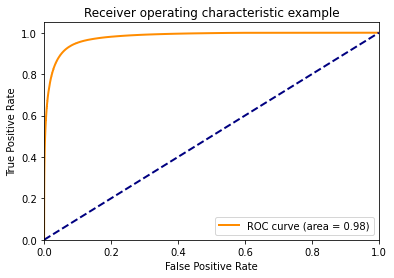

In [31]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

**Conclusions:**
1. We have defined a data set using `tf.data` API that loads 128x128px images and feeds them to the model for training/validation purposes.
2. We have implemented a custom segmentation model based on [U-NET architecture](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) and using TensorFlow functional API.
3. The custom model is trained using learning rate decay.
4. Evaluation of the trained model indicates the class imbalance in the training set (see Precision and IoU values for class '1'), although mIoU and AUC metrics' values are high overall.



In [ ]:
# Convert .ipynb to .html in the Colab enviroment
# %%shell
# jupyter nbconvert --to html /PATH/TO/YOUR/NOTEBOOKFILE.ipynb